In [1]:
import numpy as np
# import tensorflow as tf
import sys
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import tensorflow_probability as tfp

sys.path += ['../src/']

# from inference import Inference
from em import Inference
from abm import ABM
import tfmodel
import pandas as pd

np.set_printoptions(suppress=True, precision=2, threshold=2000)
from itertools import product
import seaborn as sns

import random

from sample import get_Db_per_loc
import tfmodel
from utils import ConvergenceChecker

import numpy as np
from scipy.special import softmax
import tensorflow as tf
from tqdm.autonotebook import tqdm

from collections import Counter, namedtuple
import logging
import pickle

DEBUG = False
ε = 10E-5

if DEBUG:
    from tensorflow.python import debug as tf_debug # pylint: disable=E0401

Estimate = namedtuple("Estimate", "Db, Nb, M, R, P, Nd, phi")


../src/em.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
T = 25
L = 5
K = 3

BOROUGHS = [
 '0',
 '1',
 '2',
 '3',
 '4'
]

N = 1000
Q = 500
iota = 1
alpha = 0.1
delta = 0.0625
#delta=0.25
nu = 0.1
beta = 0.5
Y = np.array([10,50,90])


abm =  ABM(N=N, K=K, L=L,
            Q=Q, Y=Y,
            alpha= alpha, 
            delta= delta,
            tau=1,
            beta=beta,
            nu=nu,
            Gammak=np.array([0.5, 0.4, 0.1]),
           )



In [4]:
def run_model(trace,T,T_all):
    np.random.seed(trace)
    initial_M = np.array(np.random.dirichlet(np.ones(K) * 0.5, size=L) * N, dtype=np.int)
    
    #Run the simplified model to be used as pseudo-truth
    sim_P, sim_M, sim_R, sim_Nd, sim_latents = abm.run(T_all, initial_M=initial_M)
    
    return [sim_P, sim_M, sim_R, sim_Nd, sim_latents]


In [5]:
all_variables_by_trace = []
for trace in range(53,63):
    sim_vars = run_model(trace,T=20,T_all=20)
    all_variables_by_trace.append(sim_vars)

In [6]:
#define ground truth
nruns = 100
T_all=25
T=20

trace = 0

list_sim_P_F_mean = []
list_sim_Nd_F_mean = []

for trace in range(10):
    
    sim_P, sim_M, sim_R, sim_Nd, sim_latents = all_variables_by_trace[trace][:]
    sim_P_F_all = np.zeros([nruns,T_all-T+1,L])
    sim_Nd_F_all = np.zeros([nruns,T_all-T+1,L])

    for run in range(nruns):

        sim_P_F, sim_M_F, sim_R_F, sim_Nd_F, sim_latents_F = \
                    abm.run(T_all-T+1, \
                            Y=Y, \
                            initial_P=sim_P[T-1], \
                            initial_M=sim_M[T-1], \
                            initial_R=sim_R[T-1], \
                            seed=run)

        sim_P_F_all[run] = sim_P_F
        sim_Nd_F_all[run] = sim_Nd_F

    sim_P_F_mean = np.mean(sim_P_F_all,axis=0)
    sim_Nd_F_mean = np.mean(sim_Nd_F_all,axis=0)
    
    list_sim_P_F_mean.append(sim_P_F_mean)
    list_sim_Nd_F_mean.append(sim_Nd_F_mean)

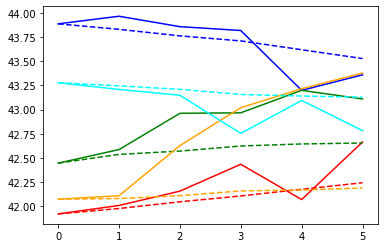

In [7]:
cols = ["red","blue","green","orange","cyan"]

for i in range(5):

    plt.plot(sim_P_F_all[0][:,i],color=cols[i])
    plt.plot(sim_P_F_mean[:,i],color=cols[i],linestyle="dashed")

In [8]:
def rmse(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))
def softmax(x):
    return np.exp(x)/sum(np.exp(x))
def softmax_matrix(xM):
    exM = np.exp(xM)
    return exM/exM.sum(axis=1)[:,None]

In [9]:
def compute_forecast_error_for_given_MT(MT,T,T_all,nruns,sim_P,sim_Nd,sim_R,gt_P,gt_Nd):
    
    sim_P_F_all = np.zeros([nruns,T_all-T+1,L])
    sim_Nd_F_all = np.zeros([nruns,T_all-T+1,L])

    for run in range(nruns):

        sim_P_F, sim_M_F, sim_R_F, sim_Nd_F, sim_latents_F = \
                    abm.run(T_all-T+1, \
                            Y=Y, \
                            initial_P=sim_P[T-1], \
                            initial_M=MT, \
                            initial_R=sim_R[T-1], \
                            seed=run)

        sim_P_F_all[run] = sim_P_F
        sim_Nd_F_all[run] = sim_Nd_F

    sim_P_F_mean = np.mean(sim_P_F_all,axis=0)
    sim_Nd_F_mean = np.mean(sim_Nd_F_all,axis=0)
    
    rmse_P = rmse(sim_P_F_mean[1:],gt_P)
    rmse_Nd = rmse(sim_Nd_F_mean[1:],gt_Nd)

    return rmse_P, rmse_Nd


def calibrate_smart_random(lambda_p,trace,T,T_all):
    
    sim_P, sim_M, sim_R, sim_Nd, sim_latents = all_variables_by_trace[trace][:]
    
    rel_P=(sim_P[T-1]/np.mean(sim_P[T-1])-1)
    p=softmax_matrix(lambda_p*np.outer(rel_P,np.array([-1,0,1])))

    rmse_P_list, rmse_Nd_list, rmse_MT_list = [], [], []
    for i in range(10):
        np.random.seed(i)
        MT = np.array([np.random.multinomial(N,p[j]) for j in range(L)])
        rmse_P, rmse_Nd = \
                compute_forecast_error_for_given_MT(MT=MT,T=T,T_all=T_all,\
                                                              nruns=100,sim_P=sim_P,sim_Nd=sim_Nd,sim_R=sim_R,\
                                                                 gt_P = list_sim_P_F_mean[trace][1:],\
                                                                 gt_Nd = list_sim_Nd_F_mean[trace][1:])      
        rmse_P_list.append(rmse_P)
        rmse_Nd_list.append(rmse_Nd)
        rmse_MT_list.append(rmse(MT,sim_M[T-1]))

    smart_random_MT_rmse_P_Nd = np.array(rmse_P_list)+np.array(rmse_Nd_list)
    smart_random_MT_rmse_MT = np.array(rmse_MT_list)
    
    return smart_random_MT_rmse_P_Nd, smart_random_MT_rmse_MT



In [13]:
n_traces = 10
n_lambdas = 20
trace_ids = range(53,63)

lambdas = np.linspace(0,40,n_lambdas)

list_smart_random_MT_rmse_P_Nd = np.zeros((n_traces,n_lambdas))
list_smart_random_MT_rmse_MT = np.zeros((n_traces,n_lambdas))

for trace in range(n_traces):
    
    trace_id = trace_ids[trace]
    for lambda_p_ix in range(n_lambdas):
        lambda_p = lambdas[lambda_p_ix]
        smart_random_MT_rmse_P_Nd, smart_random_MT_rmse_MT = calibrate_smart_random(lambda_p,trace,T=20,T_all=25)
        list_smart_random_MT_rmse_P_Nd[trace,lambda_p_ix] = np.mean(smart_random_MT_rmse_P_Nd)
        list_smart_random_MT_rmse_MT[trace,lambda_p_ix] = np.mean(smart_random_MT_rmse_MT)

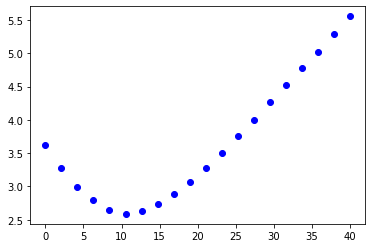

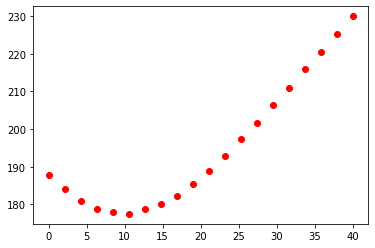

In [14]:
plt.plot(lambdas,list_smart_random_MT_rmse_P_Nd.mean(axis=0),"bo")
plt.show()
plt.plot(lambdas,list_smart_random_MT_rmse_MT.mean(axis=0),"ro")
plt.show()

In [15]:
m=list_smart_random_MT_rmse_MT.mean(axis=0)
print(lambdas[np.argmin(m)])
print(m[np.argmin(m)])

10.526315789473683
177.4812921677428


In [28]:
def analyze_forecast_performance_for_given_trace(trace,T,T_all):
    
    trace_id = trace + 53
    
    sim_P, sim_M, sim_R, sim_Nd, sim_latents = all_variables_by_trace[trace][:]
           
    
    #Random benchmark
    rmse_P_list, rmse_Nd_list, rmse_MT_list = [], [], []
    for i in range(10):
        np.random.seed(i)
        MT = np.random.dirichlet([0.5, 0.4, 0.1], size=5)*N
        rmse_P, rmse_Nd = \
                compute_forecast_error_for_given_MT(MT=MT,T=T,T_all=T_all,\
                                                              nruns=100,sim_P=sim_P,sim_Nd=sim_Nd,sim_R=sim_R,\
                                                                 gt_P = list_sim_P_F_mean[trace][1:],\
                                                                 gt_Nd = list_sim_Nd_F_mean[trace][1:])      
        rmse_P_list.append(rmse_P)
        rmse_Nd_list.append(rmse_Nd)
        rmse_MT_list.append(rmse(MT,sim_M[T-1]))

    random_MT_rmse_P = np.array(rmse_P_list)
    random_MT_rmse_Nd = np.array(rmse_Nd_list)
    random_MT_rmse_P_Nd = np.array(rmse_P_list)+np.array(rmse_Nd_list)
    random_MT_rmse_MT = np.array(rmse_MT_list)

    
    #Smart random benchmark: assign rich according to relative price of location
    #use optimized parameter
    lambda_p=lambdas[np.argmin(m)]
    
    rel_P=(sim_P[T-1]/np.mean(sim_P[T-1])-1)
    p=softmax_matrix(lambda_p*np.outer(rel_P,np.array([-1,0,1])))

    rmse_P_list, rmse_Nd_list, rmse_MT_list = [], [], []
    for i in range(10):
        np.random.seed(i)
        MT = np.array([np.random.multinomial(N,p[j]) for j in range(L)])
        rmse_P, rmse_Nd = \
                compute_forecast_error_for_given_MT(MT=MT,T=T,T_all=T_all,\
                                                              nruns=100,sim_P=sim_P,sim_Nd=sim_Nd,sim_R=sim_R,\
                                                                 gt_P = list_sim_P_F_mean[trace][1:],\
                                                                 gt_Nd = list_sim_Nd_F_mean[trace][1:])      
        rmse_P_list.append(rmse_P)
        rmse_Nd_list.append(rmse_Nd)
        rmse_MT_list.append(rmse(MT,sim_M[T-1]))

    smart_random_MT_rmse_P = np.array(rmse_P_list)
    smart_random_MT_rmse_Nd = np.array(rmse_Nd_list)
    smart_random_MT_rmse_P_Nd = np.array(rmse_P_list)+np.array(rmse_Nd_list)
    smart_random_MT_rmse_MT = np.array(rmse_MT_list)
    
     
    
    
    #Time series benchmark
    rmse_P_list, rmse_Nd_list, all_MT_list, all_R_list = [], [], [], []

    for i in range(1000,2000):
        np.random.seed(i)
        sim_P_T, sim_M_T, sim_R_T, sim_Nd_T, sim_latents_T = \
            abm.run(T=T, Y=Y, initial_P=sim_P[0], \
                    initial_M=np.random.dirichlet([0.5, 0.4, 0.1], size=5)*N,
                    initial_R=sim_R[0], seed=i)
        all_MT_list.append(sim_M_T[T-1])
        all_R_list.append(sim_R_T[T-1])
        rmse_P_list.append(rmse(sim_P_T,sim_P[0:T]))
        rmse_Nd_list.append(rmse(sim_Nd_T,sim_Nd[0:T]))

    rmse_P_Nd = np.array(rmse_P_list)+np.array(rmse_Nd_list)
    ix=np.argsort(rmse_P_Nd)[:10]
    selected_MT = np.array(all_MT_list)[ix]
    selected_R = np.array(all_R_list)[ix]

    
    rmse_P_list, rmse_Nd_list, rmse_MT_list = [], [], []
    for i in range(10):
        np.random.seed(i)
        MT = selected_MT[i]
        rmse_P, rmse_Nd = \
                compute_forecast_error_for_given_MT(MT=MT,T=T,T_all=T_all,\
                                                              nruns=100,sim_P=sim_P,sim_Nd=sim_Nd,sim_R=sim_R,\
                                                                 gt_P = list_sim_P_F_mean[trace][1:],\
                                                                 gt_Nd = list_sim_Nd_F_mean[trace][1:])      
        rmse_P_list.append(rmse_P)
        rmse_Nd_list.append(rmse_Nd)
        rmse_MT_list.append(rmse(MT,sim_M[T-1]))

    timeseries_MT_rmse_P = np.array(rmse_P_list)
    timeseries_MT_rmse_Nd = np.array(rmse_Nd_list)
    timeseries_MT_rmse_P_Nd = np.array(rmse_P_list)+np.array(rmse_Nd_list)
    timeseries_MT_rmse_MT = np.array(rmse_MT_list)
    
    
    #Constant predictor
    constant_predictor_rmse_P = np.array(rmse(list_sim_P_F_mean[trace][1:],np.tile(sim_P[T-1],(T_all-T,1))))
    constant_predictor_rmse_Nd = np.array(rmse(list_sim_Nd_F_mean[trace][1:],np.tile(sim_Nd[T-1],(T_all-T,1))))
    constant_predictor_rmse_P_Nd = np.array(constant_predictor_rmse_P+constant_predictor_rmse_Nd)
    
    #Our approach
    learned_MT_rmse_P = []
    learned_MT_rmse_Nd = []
    learned_MT_rmse_P_Nd = []
    learned_MT_rmse_MT = []
    
    f=pd.read_pickle("../data/synth-experiments/LEARNABLE-ABM-ECON-2022-09/trace-s"+\
                              str(trace_id)+"-estimate.pickle")
    MT = f.M[-1]
    
    rmse_P, rmse_Nd = \
        compute_forecast_error_for_given_MT(MT=MT,T=T,T_all=T_all,\
                                                              nruns=100,sim_P=sim_P,sim_Nd=sim_Nd,sim_R=sim_R,\
                                                                 gt_P = list_sim_P_F_mean[trace][1:],\
                                                                 gt_Nd = list_sim_Nd_F_mean[trace][1:])
    learned_MT_rmse_P.append(rmse_P)
    learned_MT_rmse_Nd.append(rmse_Nd)
    learned_MT_rmse_P_Nd.append(rmse_P+rmse_Nd)
    learned_MT_rmse_MT.append(rmse(sim_M[T-1],MT))

    learned_MT_rmse_P = np.array(learned_MT_rmse_P)
    learned_MT_rmse_Nd = np.array(learned_MT_rmse_Nd)
    learned_MT_rmse_P_Nd = np.array(learned_MT_rmse_P_Nd)
    learned_MT_rmse_MT = np.array(learned_MT_rmse_MT)

    
    results = {
        "random_MT_rmse_P":random_MT_rmse_P,
        "random_MT_rmse_Nd":random_MT_rmse_Nd,
        "random_MT_rmse_P_Nd":random_MT_rmse_P_Nd,
        "random_MT_rmse_MT":random_MT_rmse_MT,
        "smart_random_MT_rmse_P":smart_random_MT_rmse_P,
        "smart_random_MT_rmse_Nd":smart_random_MT_rmse_Nd,
        "smart_random_MT_rmse_P_Nd":smart_random_MT_rmse_P_Nd,
        "smart_random_MT_rmse_MT":smart_random_MT_rmse_MT,
        "timeseries_MT_rmse_P":timeseries_MT_rmse_P,
        "timeseries_MT_rmse_Nd":timeseries_MT_rmse_Nd,
        "timeseries_MT_rmse_P_Nd":timeseries_MT_rmse_P_Nd,
        "timeseries_MT_rmse_MT":timeseries_MT_rmse_MT,
        "constant_predictor_rmse_P":constant_predictor_rmse_P,
        "constant_predictor_rmse_Nd":constant_predictor_rmse_Nd,
        "constant_predictor_rmse_P_Nd":constant_predictor_rmse_P_Nd,
        "learned_MT_rmse_P":learned_MT_rmse_P,
        "learned_MT_rmse_Nd":learned_MT_rmse_Nd,
        "learned_MT_rmse_P_Nd":learned_MT_rmse_P_Nd,
        "learned_MT_rmse_MT":learned_MT_rmse_MT
    }
    
    
    return results
    


In [29]:
results=analyze_forecast_performance_for_given_trace(trace=1,T=20,T_all=25)

In [30]:
results

{'random_MT_rmse_P': array([0.26, 0.28, 0.09, 0.21, 0.23, 0.24, 0.2 , 0.3 , 0.23, 0.15]),
 'random_MT_rmse_Nd': array([13.43, 14.99,  5.22, 12.62, 13.06, 12.43, 10.53, 17.16, 12.01,
         8.38]),
 'random_MT_rmse_P_Nd': array([13.69, 15.27,  5.32, 12.82, 13.29, 12.68, 10.73, 17.46, 12.24,
         8.53]),
 'random_MT_rmse_MT': array([370.47, 511.92, 304.55, 424.94, 361.61, 481.53, 454.3 , 489.57,
        373.18, 368.8 ]),
 'smart_random_MT_rmse_P': array([0.05, 0.05, 0.05, 0.05, 0.04, 0.05, 0.05, 0.04, 0.05, 0.05]),
 'smart_random_MT_rmse_Nd': array([2.64, 2.53, 2.61, 2.64, 2.54, 2.75, 2.55, 2.28, 2.53, 2.45]),
 'smart_random_MT_rmse_P_Nd': array([2.69, 2.57, 2.66, 2.69, 2.59, 2.8 , 2.6 , 2.33, 2.58, 2.5 ]),
 'smart_random_MT_rmse_MT': array([164.79, 162.77, 166.96, 157.93, 160.14, 164.99, 164.71, 151.48,
        173.91, 159.74]),
 'timeseries_MT_rmse_P': array([0.01, 0.02, 0.03, 0.03, 0.02, 0.03, 0.02, 0.03, 0.02, 0.03]),
 'timeseries_MT_rmse_Nd': array([0.74, 1.21, 1.53, 1.44, 1.1

In [39]:
results_list = []
for trace in range(10):
    results_list.append(analyze_forecast_performance_for_given_trace(trace=trace,T=20,T_all=25))

In [42]:
mean_random_MT_rmse_P = []
mean_random_MT_rmse_Nd = []
mean_random_MT_rmse_P_Nd = []
mean_random_MT_rmse_MT = []
mean_smart_random_MT_rmse_P = []
mean_smart_random_MT_rmse_Nd = []
mean_smart_random_MT_rmse_P_Nd = []
mean_smart_random_MT_rmse_MT = []
mean_timeseries_MT_rmse_P = []
mean_timeseries_MT_rmse_Nd = []
mean_timeseries_MT_rmse_P_Nd = []
mean_timeseries_MT_rmse_MT = []
mean_constant_predictor_rmse_P = []
mean_constant_predictor_rmse_Nd = []
mean_constant_predictor_rmse_P_Nd = []
mean_learned_MT_rmse_P = []
mean_learned_MT_rmse_Nd = []
mean_learned_MT_rmse_P_Nd = []
mean_learned_MT_rmse_MT = []

for i in range(10):
    mean_random_MT_rmse_P.append(np.mean(results_list[i]["random_MT_rmse_P"]))
    mean_random_MT_rmse_Nd.append(np.mean(results_list[i]["random_MT_rmse_Nd"]))
    mean_random_MT_rmse_P_Nd.append(np.mean(results_list[i]["random_MT_rmse_P_Nd"]))
    mean_random_MT_rmse_MT.append(np.mean(results_list[i]["random_MT_rmse_MT"]))
    mean_smart_random_MT_rmse_P.append(np.mean(results_list[i]["smart_random_MT_rmse_P"]))
    mean_smart_random_MT_rmse_Nd.append(np.mean(results_list[i]["smart_random_MT_rmse_Nd"]))
    mean_smart_random_MT_rmse_P_Nd.append(np.mean(results_list[i]["smart_random_MT_rmse_P_Nd"]))
    mean_smart_random_MT_rmse_MT.append(np.mean(results_list[i]["smart_random_MT_rmse_MT"]))
    mean_timeseries_MT_rmse_P.append(np.mean(results_list[i]["timeseries_MT_rmse_P"]))
    mean_timeseries_MT_rmse_Nd.append(np.mean(results_list[i]["timeseries_MT_rmse_Nd"]))
    mean_timeseries_MT_rmse_P_Nd.append(np.mean(results_list[i]["timeseries_MT_rmse_P_Nd"]))
    mean_timeseries_MT_rmse_MT.append(np.mean(results_list[i]["timeseries_MT_rmse_MT"]))
    mean_constant_predictor_rmse_P.append(np.mean(results_list[i]["constant_predictor_rmse_P"]))
    mean_constant_predictor_rmse_Nd.append(np.mean(results_list[i]["constant_predictor_rmse_Nd"]))
    mean_constant_predictor_rmse_P_Nd.append(np.mean(results_list[i]["constant_predictor_rmse_P_Nd"]))
    mean_learned_MT_rmse_P.append(np.mean(results_list[i]["learned_MT_rmse_P"]))
    mean_learned_MT_rmse_Nd.append(np.mean(results_list[i]["learned_MT_rmse_Nd"]))
    mean_learned_MT_rmse_P_Nd.append(np.mean(results_list[i]["learned_MT_rmse_P_Nd"]))
    mean_learned_MT_rmse_MT.append(np.mean(results_list[i]["learned_MT_rmse_MT"]))

In [43]:
mean_random_MT_rmse_P_Nd

[12.283420615443413,
 12.203527047548139,
 12.227095270252748,
 11.91056452789546,
 12.160330898606452,
 11.271472980070847,
 11.124527359241977,
 11.982110553798062,
 11.343762777892596,
 11.063032807116555]

In [44]:
df = pd.DataFrame({
    'rmse':np.concatenate([mean_smart_random_MT_rmse_P_Nd,\
                           mean_timeseries_MT_rmse_P_Nd,mean_constant_predictor_rmse_P_Nd,\
                           mean_learned_MT_rmse_P_Nd]),
    'group':np.concatenate([np.repeat("smart random MT",10),\
                          np.repeat("time series MT",10),\
                            np.repeat("constant predictor",10),\
                            np.repeat("learned MT",10)])
})
df

,rmse,group
0,3.194479,smart random MT
1,2.600877,smart random MT
2,3.978491,smart random MT
3,2.169362,smart random MT
4,3.666002,smart random MT
5,1.793585,smart random MT
6,1.225829,smart random MT
7,3.428890,smart random MT
8,1.901068,smart random MT
9,1.907576,smart random MT


In [45]:
df.to_csv("../data/main-figure-forecasting.csv", index=False)

df1 = pd.DataFrame({
    'rmse':np.concatenate([mean_smart_random_MT_rmse_P,\
                           mean_timeseries_MT_rmse_P,mean_constant_predictor_rmse_P,mean_learned_MT_rmse_P]),
    'group':np.concatenate([np.repeat("smart random MT",10),\
                          np.repeat("time series MT",10),\
                            np.repeat("constant predictor",10),\
                            np.repeat("learned MT",10)])
})
df1.to_csv("../data/main-figure-forecasting-only-P.csv", index=False)

df2 = pd.DataFrame({
    'rmse':np.concatenate([mean_smart_random_MT_rmse_Nd,\
                           mean_timeseries_MT_rmse_Nd,mean_constant_predictor_rmse_Nd,mean_learned_MT_rmse_Nd]),
    'group':np.concatenate([np.repeat("smart random MT",10),\
                          np.repeat("time series MT",10),\
                            np.repeat("constant predictor",10),\
                            np.repeat("learned MT",10)])
})
df2.to_csv("../data/main-figure-forecasting-only-Nd.csv", index=False)

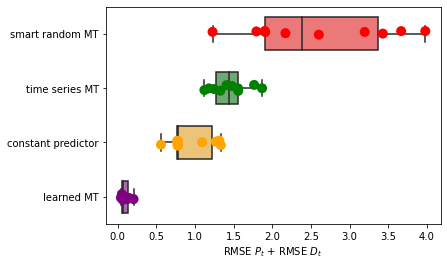

In [46]:
plt.figure(figsize=(6,4))



my_pal = {"smart random MT": "red", "time series MT":"green","constant predictor":"orange",
         "learned MT": "purple"}

sns.stripplot(x="rmse", y="group", data=df, palette=my_pal,
              size=10,  linewidth=0, jitter=0.06)


ax = sns.boxplot(x="rmse", y="group", data=df,
            whis=[0, 100], width=.6, palette=my_pal)


ax.set_xlabel("RMSE $P_t$ + RMSE $D_t$")
ax.set_ylabel("")


for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

# plt.savefig("../paper/plots/forecasting.pdf",bbox_inches="tight")

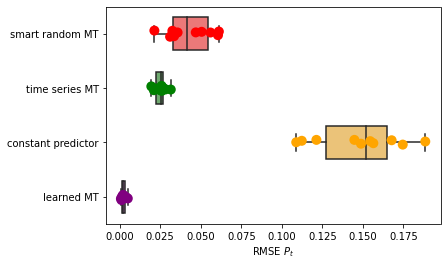

In [47]:
plt.figure(figsize=(6,4))



my_pal = {"smart random MT": "red", "time series MT":"green","constant predictor":"orange",
         "learned MT": "purple"}

sns.stripplot(x="rmse", y="group", data=df1, palette=my_pal,
              size=10,  linewidth=0, jitter=0.06)


ax = sns.boxplot(x="rmse", y="group", data=df1,
            whis=[0, 100], width=.6, palette=my_pal)


ax.set_xlabel("RMSE $P_t$ ")
ax.set_ylabel("")


for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

# plt.savefig("../paper/plots/forecasting.pdf",bbox_inches="tight")

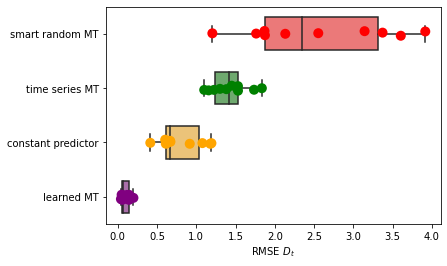

In [48]:
plt.figure(figsize=(6,4))



my_pal = {"smart random MT": "red", "time series MT":"green","constant predictor":"orange",
         "learned MT": "purple"}

sns.stripplot(x="rmse", y="group", data=df2, palette=my_pal,
              size=10,  linewidth=0, jitter=0.06)


ax = sns.boxplot(x="rmse", y="group", data=df2,
            whis=[0, 100], width=.6, palette=my_pal)


ax.set_xlabel("RMSE $D_t$ ")
ax.set_ylabel("")


for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .6))

# plt.savefig("../paper/plots/forecasting.pdf",bbox_inches="tight")